# 11. Variational Auto-Encoder

_Exercise: Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples._

## Prepare environment

In [221]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow_datasets as tfds

import numpy as np

from keras import layers
import keras

import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [249]:
# Parameters
BATCH_SIZE = 128
INPUT_SHAPE = (28, 28, 1)
LATENT_DIM = 16
EPOCHS = 10 # 100

## Prepare dataset

In [223]:
ds, info = tfds.load(
    "mnist",
    split=["train", "test"],
    with_info=True,
    shuffle_files=True
)

In [224]:
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/martin/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [225]:
ds_train, ds_test = ds
print(len(list(ds_train)))
print(len(list(ds_test)))

60000
10000


In [226]:
for example in ds_train.take(1):
    image = example["image"]
    print(image.shape)


(28, 28, 1)


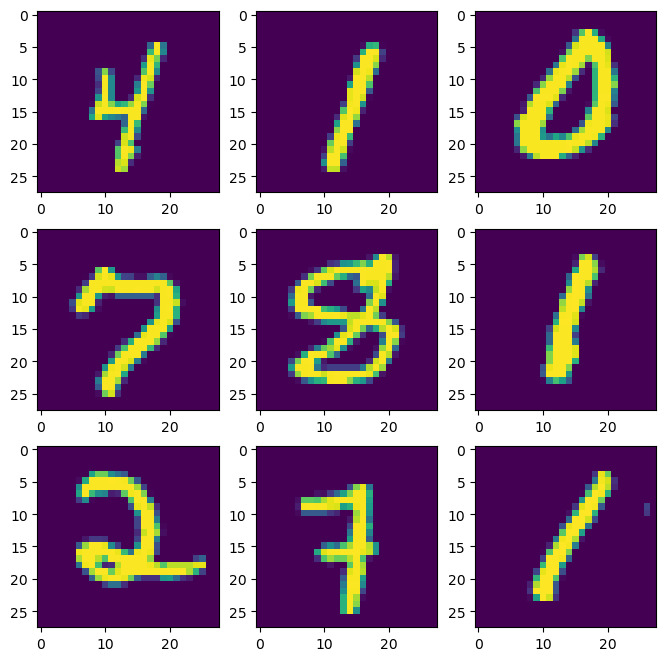

In [227]:
plt.figure(1, figsize=(8,8))
for pos, example in enumerate(ds_train.take(9)):
    plt.subplot(3, 3, pos + 1)
    image = example["image"]
    plt.imshow(image)
plt.show()

In [228]:
AUTO = tf.data.AUTOTUNE

def scale(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

ds_train = (
    ds_train.shuffle(1024)
    .map(lambda X: X["image"])
    .map(scale, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ds_test = (
    ds_test
    .map(lambda X: X["image"])
    .map(scale, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

### Train Variational Auto-Encoder and Generate new images

In [250]:
class BeanVAE(keras.Model):
    def __init__(self, latent_dim):
        super(BeanVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = keras.Sequential([
            layers.Input(shape=INPUT_SHAPE),
            layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
            layers.Flatten(),
            layers.Dense(16, activation='relu'),
        ])

        # Mean and variance layers
        self.dense_mean = layers.Dense(latent_dim, name='mean')
        self.dense_log_var = layers.Dense(latent_dim, name='log_var')

        # Decoder
        self.decoder = keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(7 * 7 * 64, activation='relu'),
            layers.Reshape((7, 7, 64)),
            layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')
        ])

    def encode(self, x):
        x = self.encoder(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

    def decode(self, z):
        return self.decoder(z)

    def call(self, inputs):
        mean, log_var = self.encode(inputs)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mean, log_var

    def sample(self, n_samples):
        z = tf.random.normal(shape=(n_samples, self.latent_dim))
        return self.decode(z)

In [251]:
def vae_loss_function(inputs, outputs, mean, log_var):
    # Reconstruction loss
    reconstruction_loss = tf.reduce_mean(
        keras.losses.binary_crossentropy(inputs, outputs) * INPUT_SHAPE[0] * INPUT_SHAPE[1] * INPUT_SHAPE[2]
    )

    # KL divergence
    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))

    return reconstruction_loss + kl_loss

In [252]:
@tf.function
def train_step(model, optimizer, x):
    with tf.GradientTape() as tape:
        # Forward pass
        reconstructed, mean, log_var = model(x)

        # Compute loss
        loss = vae_loss_function(x, reconstructed, mean, log_var)

    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [253]:
def visualize_reconstructions(model, images, epoch):
    n = 10
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.title("Original")
        plt.axis("off")

        # Display reconstruction
        img = np.expand_dims(images[i], axis=0)
        reconstruction, _, _ = model(img)
        reconstruction = reconstruction.numpy()[0]

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstruction)
        plt.title("Reconstructed")
        plt.axis("off")

    plt.savefig(f"reconstructions_epoch_{epoch+1}.png")
    plt.close()

In [254]:
def visualize_generated_samples(model, n_samples, epoch):
    generated_images = model.sample(n_samples).numpy()

    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.title("Generated")

    plt.savefig(f"generated_samples_epoch_{epoch+1}.png")
    plt.close()

In [255]:
def train_vae(train_dataset, val_dataset, model_save_path="bean_vae_model.weights.h5"):
    # Create model and optimizer
    model = BeanVAE(LATENT_DIM)
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)

    # Training loop
    print("Starting training...")
    loss_history = []
    val_loss_history = []

    for epoch in range(EPOCHS):
        # Training
        epoch_loss = 0
        num_batches = 0

        for batch in train_dataset:
            loss = train_step(model, optimizer, batch)
            epoch_loss += loss
            num_batches += 1

        epoch_loss /= num_batches
        loss_history.append(epoch_loss)

        # Validation
        val_epoch_loss = 0
        val_num_batches = 0

        for val_batch in val_dataset:
            val_reconstructed, val_mean, val_log_var = model(val_batch)
            val_loss = vae_loss_function(val_batch, val_reconstructed, val_mean, val_log_var)
            val_epoch_loss += val_loss
            val_num_batches += 1

        val_epoch_loss /= val_num_batches
        val_loss_history.append(val_epoch_loss)

        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")

        # Generate and save some example reconstructions
        if (epoch + 1) % 5 == 0 or epoch == 0:
            visualize_reconstructions(model, list(tfds.as_numpy(ds_test.take(1)))[0][:10], epoch)
            visualize_generated_samples(model, 10, epoch)

    # Save the model
    model.save_weights(model_save_path)

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('VAE Training and Validation Loss')
    plt.legend()
    plt.savefig('vae_loss_curves.png')
    plt.close()

    return model, loss_history, val_loss_history

In [256]:
model, loss_history, val_loss_history = train_vae(ds_train, ds_test)

Starting training...
Epoch 1/10, Loss: 166.8753, Val Loss: 131.7078
Epoch 2/10, Loss: 126.2995, Val Loss: 121.4307
Epoch 3/10, Loss: 120.1992, Val Loss: 117.7700
Epoch 4/10, Loss: 117.3259, Val Loss: 117.1346
Epoch 5/10, Loss: 115.9898, Val Loss: 114.5607
Epoch 6/10, Loss: 114.8273, Val Loss: 115.0268
Epoch 7/10, Loss: 114.1221, Val Loss: 113.3066
Epoch 8/10, Loss: 113.2266, Val Loss: 112.8565
Epoch 9/10, Loss: 112.8396, Val Loss: 112.2832
Epoch 10/10, Loss: 112.2985, Val Loss: 112.6450


In [257]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

encoded_imgs = model.encoder(x_test)

In [258]:
# 3. Perform clustering on the latent space
n_clusters = len(np.unique(y_test))  # Assuming the number of clusters equals the number of classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(encoded_imgs)

# 4. Compute the ARI
ari_score = adjusted_rand_score(y_test, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari_score}")

Adjusted Rand Index (ARI): 0.4921399002535537
